# Convolutional Variational Autoencoder example using MNIST dataset (Tensorflow backend)
## Introduction to CVAE
CVAE are Convolutional Variational Autoencoder. They are composed by two models using convolutions: an Encoder to represent the input in a latent dimension, and a Decoder that will generate data from the latent dimension to the input space. The figure below illustrates the main idea of CVAE. <br> <br> In this example, we will use CVAE to generate data similar to MNIST dataset with Tensorflow backend. All training details including model structure, data preprocessing, loss calculation ... etc come from the reference of Tensorflow CVAE tutorial (https://www.tensorflow.org/tutorials/generative/cvae)
<img src="VAE_complete.png"> [img source: https://mlexplained.com/2017/12/28/an-intuitive-explanation-of-variational-autoencoders-vaes-part-1/]

## Import the required libraries

In [1]:
import tensorflow as tf
import fastestimator as fe
import numpy as np
import tempfile
import matplotlib.pyplot as plt
from typing import Any, Dict, Tuple


In [2]:
#training parameters
epochs = 20
batch_size = 100
max_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

## Step 1 - Data and `Pipeline` preparation
In this step, we will load MNIST training and validation datasets and prepare FastEstimator's pipeline.

### Load dataset 
Using fastestimator API to load the MNIST dataset. 

In [3]:
from fastestimator.dataset.data.mnist import load_data

train_data, test_data = load_data()

### Set up preprocess pipline
In this example, the data preprocessing steps include exapanding image dimension and normalizing the pixel value to range [0, 1], and binarizing pixel value. We set up those processing step using `Ops` and meanwhile define the data source (loaded dataset) and batch size. 

In [4]:
from fastestimator.op.numpyop import Binarize, ExpandDims, Minmax

pipeline = fe.Pipeline(
    train_data=train_data,
    batch_size=batch_size,
    ops=[
        ExpandDims(inputs="x", outputs="x_out"), # change image size: (None, 28, 28) -> (None, 28, 28, 1) 
        Minmax(inputs="x_out", outputs="x_out"), # normalize pixel value: [0, 255] -> [0, 1] 
        Binarize(inputs="x_out", outputs="x_out", threshold=0.5) # binarize pixel value
    ])

### Validate `Pipeline`
In order to make sure the pipeline works as expected, we need to visualize the output of pipeline image and check its size.
`Pipeline.get_results` will return a batch data of pipeline output.  


In [5]:
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]
print("the pipeline input data size: {}".format(data_xin.numpy().shape))
print("the pipeline output data size: {}".format(data_xout.numpy().shape))


the pipeline input data size: (100, 28, 28)
the pipeline output data size: (100, 28, 28, 1)


Randomly select 5 sample and visualize the difference between pipeline input and output.

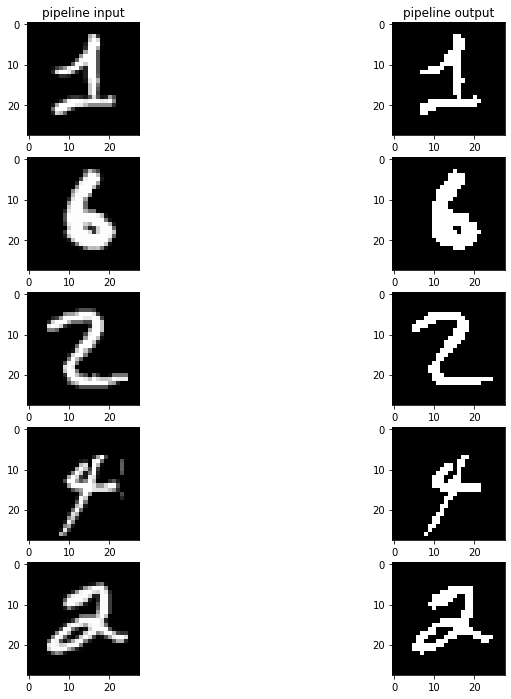

In [6]:
sample_num = 5

fig, axs = plt.subplots(sample_num, 2, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")


for i, j in enumerate(np.random.randint(low=0, high=batch_size-1, size=sample_num)):
    img_in = data_xin.numpy()[j]
    axs[i,0].imshow(img_in, cmap="gray")
    
    img_out = data_xout.numpy()[j,:,:,0]
    axs[i,1].imshow(img_out, cmap="gray")
    

## Step 2 - `Network` construction
**FastEstimator supports both Pytorch and Tensorlfow, so this section can use both backend to implement.** <br>
We are going to only demonstate the Tensorflow way in this example.

### Model construction
Both models' definition are implemented in Tensorflow and intantiated by calling `fe.build` which also associates the model with specific optimizers.

In [7]:
LATENT_DIM = 50

def encoder_net():
    infer_model = tf.keras.Sequential()
    infer_model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1)))
    infer_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'))
    infer_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'))
    infer_model.add(tf.keras.layers.Flatten())
    infer_model.add(tf.keras.layers.Dense(LATENT_DIM + LATENT_DIM))
    return infer_model


def decoder_net():
    generative_model = tf.keras.Sequential()
    generative_model.add(tf.keras.layers.InputLayer(input_shape=(LATENT_DIM, )))
    generative_model.add(tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu))
    generative_model.add(tf.keras.layers.Reshape(target_shape=(7, 7, 32)))
    generative_model.add(
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))
    generative_model.add(
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))
    generative_model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation='sigmoid'))
    return generative_model

encode_model = fe.build(model_fn=encoder_net, optimizer_fn="adam", model_names="encoder")
decode_model = fe.build(model_fn=decoder_net, optimizer_fn="adam", model_names="decoder")

### Customize `Ops` 
`Ops` are the basic component of `Network`. They can be logic for loss calculation, model update units, and even model itself is also considered as an `Op`. Some `Ops` are pre-defined in FastEstimator like cross entropy, but for the logic that is not there yet, users need to define their own `Ops`. **Please keep all `Ops` backend consistent with model backend**. (All `Ops`need to be implemented in Tensorflow if the model is built from Tensorflow. Same for Pytorch.)      

#### Customize Ops - ReparameterizepOp
Because the encoder output serves as mean and log of variance, we need to split them into two outputs. 

In [8]:
from fastestimator.op import TensorOp

class SplitOp(TensorOp):
    """To split the infer net output into two """
    def forward(self, data: tf.Tensor, state: Dict[str, Any]) -> Tuple[tf.Tensor, tf.Tensor]:
        mean, logvar = tf.split(data, num_or_size_splits=2, axis=1)
        return mean, logvar

#### Customize Ops - ReparameterizepOp
In this example case, the input of the decoder is the random sample from the normal distiribution that both mean and vairation are the output of the encoder. So we are going to build a op called "ReparameterizepOp" to do this jobs.

In [9]:
class ReparameterizepOp(TensorOp):
    def forward(self, data: Tuple[tf.Tensor, tf.Tensor], state: Dict[str, Any]) -> tf.Tensor:
        mean, logvar = data
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

#### Customize Ops - CVAELoss

In [10]:
import math

class CVAELoss(TensorOp):
    def forward(self, data: Tuple[tf.Tensor, ...], state: Dict[str, Any]) -> tf.Tensor:
        cross_ent_mean, mean, logvar, z = data   
        
        cross_ent_total = cross_ent_mean * (28 * 28 * 1) # cross_ent_mean is the average cross entropy over pixels and batches 
                                                         # make it total cross entropy over pixels 
        logpz = self._log_normal_pdf(z, 0., 0.)
        logqz_x = self._log_normal_pdf(z, mean, logvar)
        total_loss = cross_ent_total + tf.reduce_mean(-logpz + logqz_x)

        return total_loss
    
    @staticmethod
    def _log_normal_pdf(sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * tf.constant(math.pi))
        return tf.reduce_sum(-.5 * ((sample - mean)**2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

### `Network` definition
We are going to connect all models and `Ops` together into a `Network` 

In [11]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

network = fe.Network(ops=[
    ModelOp(model=encode_model, inputs="x_out", outputs="meanlogvar"),
    SplitOp(inputs="meanlogvar", outputs=("mean", "logvar")),
    ReparameterizepOp(inputs=("mean", "logvar"), outputs="z"), 
    ModelOp(model=decode_model, inputs="z", outputs="x_logit"),
    CrossEntropy(inputs=("x_logit", "x_out"), outputs="cross_entropy"), 
    CVAELoss(inputs=("cross_entropy", "mean", "logvar", "z"), outputs="loss", mode="!infer"),
    UpdateOp(model=encode_model, loss_name="loss"),
    UpdateOp(model=decode_model, loss_name="loss"),
])

## Step 3 - `Estimator` definition and training
In this step, we define the `Estimator` to compile the `Network` and `Pipeline` and indicate in `traces` that we want to save the best models. At the end, using `estimator.fit` method function to start the training process

In [12]:
from fastestimator.trace.io import ModelSaver

traces = [ModelSaver(model=encode_model, save_dir=save_dir, frequency=epochs-1), 
          ModelSaver(model=decode_model, save_dir=save_dir, frequency=epochs-1)]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         max_steps_per_epoch=max_steps_per_epoch,
                         log_steps=600)

estimator.fit() # start the training process

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 0; encoder_lr: 0.001; decoder_lr: 0.001; 
FastEstimator-Train: step: 0; loss: 544.8315; 
Saved model to /tmp/tmph849run7/encoder_epoch_0.h5
Saved model to /tmp/tmph849run7/decoder_epoch_0.h5
FastEstimator-Train: step: 600; epoch: 0; epoch_time: 6.57 sec; 
FastEstimator-Train: step: 600; loss: 104.150696; steps/sec: 181.54; 
FastEstimator-Train: step: 1200; epoch: 1; epoch_time: 3.29 sec; 
FastEstimator-Train: step: 1200; loss: 91.99516; steps/sec: 180.6; 
FastEstimator-Train: step: 1800; epoch: 2; epoch_time: 3.28 sec; 
FastEsti

## Inference the image
Once finishing training the models, we will like to try to run those models on some testing data. We randomly select 5 images from testing dataset and infer them image by image.

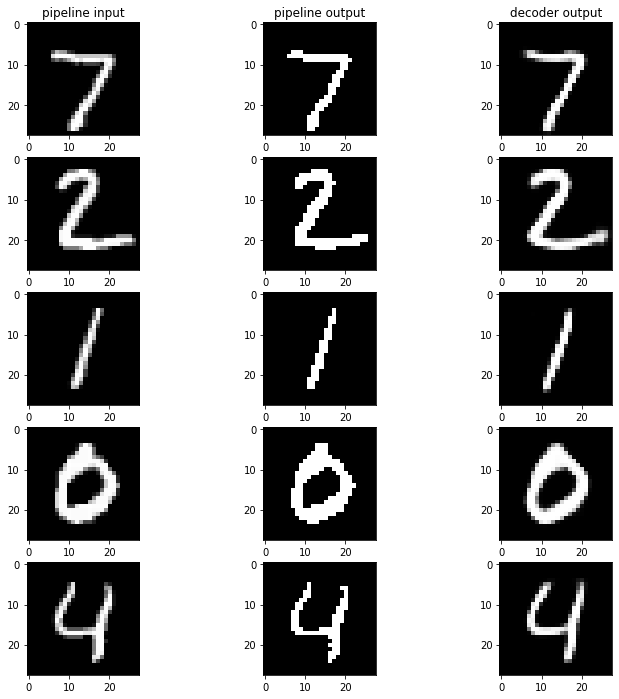

In [13]:
sample_num = 5

fig, axs = plt.subplots(sample_num, 3, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")
axs[0,2].set_title("decoder output")

for i in range(sample_num):
    data = {"x": test_data["x"][i]}
    axs[i,0].imshow(data["x"], cmap="gray")
    
    # run the pipeline
    pipeline.transform(data, mode="infer") 
    img = data["x_out"].squeeze(axis=(0,3))
    axs[i,1].imshow(img, cmap="gray")
    
    # run the network
    data = network.transform(data, mode="infer")
    img = data["x_logit"].numpy().squeeze(axis=(0,3))
    axs[i,3].imshow(img, cmap="gray")